In [1]:
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
from fastcore.utils import load_pickle

plt.style.use(["science", "nature"])

colors = ["#0C5DA5", "#00B945", "#FF9500", "#FF2C00", "#845B97", "#474747", "#9e9e9e"]

In [11]:
all_runs = glob("results/polymer_classification/*polymers*.pkl")


In [3]:
def compile_data(file):
    res = load_pickle(file)
    model_type = res["model_type"]
    train_size = res["train_size"]
    prefix = res["prefix"]
    acc = res["cm"].ACC_Macro
    f1_macro = res["cm"].F1_Macro
    f1_micro = res["cm"].F1_Micro

    return {
        "model_type": model_type,
        "train_size": train_size,
        "prefix": prefix,
        "acc": acc,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
    }


In [4]:
all_results = [compile_data(run) for run in all_runs]


In [5]:
all_results = pd.DataFrame(all_results)


In [6]:
aggregated = all_results.groupby(["model_type", "prefix", "train_size"]).agg(
    ["mean", "std"]
)


In [7]:
all_results["prefix"].unique()


array(['', "I'm an expert polymer chemist "], dtype=object)

In [8]:
aggregated.loc["ada"].loc[""].index


Int64Index([10, 50, 100, 200, 500, 1000, 2000], dtype='int64', name='train_size')

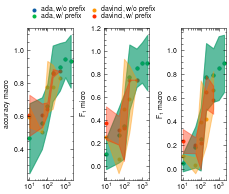

In [9]:
fig, ax = plt.subplots(1, 3, sharex="all")


ada_no_prefix = aggregated.loc["ada"].loc[""]
ada_prefix = aggregated.loc["ada"].loc["I'm an expert polymer chemist "]

davinci_no_prefix = aggregated.loc["davinci"].loc[""]
davinci_prefix = aggregated.loc["davinci"].loc["I'm an expert polymer chemist "]

alpha=.4

for i, metric in enumerate(["acc", "f1_micro", "f1_macro"]):
    ax[i].scatter(
        ada_no_prefix.index,
        ada_no_prefix[metric]["mean"],
        label="ada, w/o prefix" if i == 0 else None,
        c=colors[0],
    )
    ax[i].scatter(
        ada_prefix.index,
        ada_no_prefix[metric]["mean"],
        label="ada, w/ prefix" if i == 0 else None,
        c=colors[1],
    )
    ax[i].scatter(
        davinci_no_prefix.index,
        davinci_no_prefix[metric]["mean"],
        label="davinci, w/o prefix" if i == 0 else None,
        c=colors[2],
    )
    ax[i].scatter(
        davinci_prefix.index,
        davinci_prefix[metric]["mean"],
        label="davinci, w/ prefix" if i == 0 else None,
        c=colors[3],
    )

    ax[i].fill_between(
        ada_no_prefix.index,
        ada_no_prefix[metric]["mean"] - ada_no_prefix[metric]["std"],
        ada_no_prefix[metric]["mean"] + ada_no_prefix[metric]["std"],
        color=colors[0],
        alpha=alpha,
        interpolate=True
    )
    ax[i].fill_between(
        ada_prefix.index,
        ada_no_prefix[metric]["mean"] - ada_no_prefix[metric]["std"],
        ada_no_prefix[metric]["mean"] + ada_no_prefix[metric]["std"],
        color=colors[1],
        alpha=alpha,
        interpolate=True
    )
    ax[i].fill_between(
        davinci_no_prefix.index,
        davinci_no_prefix[metric]["mean"] - davinci_no_prefix[metric]["std"],
        davinci_no_prefix[metric]["mean"] + davinci_no_prefix[metric]["std"],
        color=colors[2],
        alpha=alpha,
        interpolate=True
    )
    ax[i].fill_between(
        davinci_prefix.index,
        davinci_prefix[metric]["mean"] - davinci_prefix[metric]["std"],
        davinci_prefix[metric]["mean"] + davinci_prefix[metric]["std"],
        color=colors[3],
        alpha=alpha,
        interpolate=True
    )



ax[0].set_ylabel('accuracy macro')
ax[1].set_ylabel(r'F$_1$ micro')
ax[2].set_ylabel(r'F$_1$ macro')

fig.legend(bbox_to_anchor=(0.7,1.1), ncol=2, handletextpad=0, labelspacing=0, columnspacing=0)
ax[0].set_xscale("log")
fig.tight_layout()
fig.savefig('polymer_learning_curve.pdf', bbox_inches=False)

Some conclusions: 

- Using the bigger model (`davinci`) perhaps better in very low data regime. For more data, there is really no point in using it. 
- Adding the prefix did not really help.